<a href="https://colab.research.google.com/github/totti0223/deep_learning_for_biologists_with_keras/blob/master/notebooks/deepyeast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yeast GFP protein localization classification with CNN

![yeast_image](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/yeast.jpg)
Above image adopted from http://kodu.ut.ee/~leopoldp/2016_DeepYeast/

##Reference
*Accurate Classification of Protein Subcellular Localization from High-Throughput Microscopy Images Using Deep Learning
Tanel Pärnamaa and Leopold Parts
G3: GENES, GENOMES, GENETICS May 1, 2017 vol. 7 no. 5 1385-1392; https://doi.org/10.1534/g3.116.033654*

http://kodu.ut.ee/~leopoldp/2016_DeepYeast/

## Assistant codes to run the notebook.

In [3]:
#@title
import csv
import numpy as np
import os
import math

import itertools

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from skimage.exposure import equalize_adapthist

from skimage.io import imread
from skimage.transform import resize

import keras
import keras.backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import layers,models
from keras.regularizers import l2


def load_label_names(mode="main"):
    ''''
    returns list of label names used in the study. mode="main" by default
    switch to true to get labels for transfer learning dataset
    '''
    if mode == "main":
        label_names = ['Cell_periphery','Cytoplasm',
               'endosome','ER','Golgi',
               'Mitochondrion','Nuclear_Periphery',
               'Nucleolus','Nucleus','Peroxisome',
               'Spindle_pole','Vacuole']
    elif mode == "transfer":
        label_names = ['actin','bud neck','lipid practice','microtubule']
    else:
        print("mode must be main or transfer.")
        return 0

    return label_names

def number2label(label,mode="main"):
    '''
    input: a yeast subcellular localization number(s) of int (or numpy with length 1)
    returns:decoded localization string(s) numpy
    transfer=False by default for training dataset
    switch to True to get labels for transfer learning dataset
    '''
    label_names=load_label_names(mode=mode)
    return label_names[label]

def load_data(mode="main"):
    '''
    Codes adopted from keras https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py
    Downloads and load files from if it not already in the cache..
    by default, it will be saved to ~/.keras

    mode = "main"(default) or "transfer"
    '''
    print("Will load train,test,valid data for dataset: %s" % mode)
    if mode == "main":
        paths = ["main.tar.gz","HOwt_train.txt","HOwt_val.txt","HOwt_test.txt"]
        data_path = get_file(paths[0],
                             origin="http://kodu.ut.ee/~leopoldp/2016_DeepYeast/data/main.tar.gz",
                             extract=True,
                             cache_subdir='deepyeast')
        train_path = get_file(paths[1],origin="http://kodu.ut.ee/~leopoldp/2016_DeepYeast/code/reports/HOwt_train.txt",
                             cache_subdir='deepyeast')
        val_path = get_file(paths[2],origin="http://kodu.ut.ee/~leopoldp/2016_DeepYeast/code/reports/HOwt_val.txt",
                             cache_subdir='deepyeast')
        test_path = get_file(paths[3],origin="http://kodu.ut.ee/~leopoldp/2016_DeepYeast/code/reports/HOwt_test.txt",
                             cache_subdir='deepyeast')
    elif mode == "transfer":
        paths = ["transfer.tar.gz","HOwt_transfer_train.txt","HOwt_transfer_val.txt","HOwt_transfer_test.txt"]

        data_path = get_file(paths[0], 
                             origin='http://kodu.ut.ee/~leopoldp/2016_DeepYeast/data/transfer.tar.gz',
                             extract=True,
                             cache_subdir='deepyeast_transfer')   
        train_path = get_file(paths[1], 
                              origin='http://kodu.ut.ee/~leopoldp/2016_DeepYeast/code/image_prep/data/HOwt_transfer_train.txt', 
                              cache_subdir='deepyeast_transfer')
        val_path = get_file(paths[2], 
                            origin='http://kodu.ut.ee/~leopoldp/2016_DeepYeast/code/image_prep/data/HOwt_transfer_val.txt', 
                            cache_subdir='deepyeast_transfer')
        test_path = get_file(paths[3], 
                             origin='http://kodu.ut.ee/~leopoldp/2016_DeepYeast/code/image_prep/data/HOwt_transfer_test.txt', 
                             cache_subdir='deepyeast_transfer')
    else:
        print("mode must be main or transfer.")
        return 0
    
    data_path, _ = os.path.split(data_path)

    X_train = []
    X_valid = []
    X_test = []
    y_train = []
    y_valid = []
    y_test = []

    with open(train_path) as f:
        count = sum(1 for row in csv.reader(f))
        print("loading train dataset with %s images" % count)
        f.seek(0)
        reader = csv.reader(f)    
        
        for row in reader: 
            row = row[0].split(" ") 
            image_path = row[0]
            image_path = os.path.join(data_path,image_path)
            image = imread(image_path)
            image = resize(image,(64,64)) #this will change the numpy range to 0 to 1
            X_train.append(image)    
            label = row[1]
            y_train.append(label)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = np_utils.to_categorical(y_train)

    with open(val_path) as f:
        count = sum(1 for row in csv.reader(f))
        print("loading valid dataset with %s images" % count)
        f.seek(0)
        reader = csv.reader(f)
        for row in reader: 
            row = row[0].split(" ") 
            image_path = row[0]
            image_path = os.path.join(data_path,image_path)
            image = imread(image_path)
            image = resize(image,(64,64))
            X_valid.append(image)
            label = row[1]
            y_valid.append(label)
    X_valid = np.array(X_valid)
    y_valid = np.array(y_valid)
    y_valid = np_utils.to_categorical(y_valid)

    with open(test_path) as f:
        count = sum(1 for row in csv.reader(f))
        print("loading test dataset with %s images" % count)
        f.seek(0)
        reader = csv.reader(f)
        for row in reader:
            row = row[0].split(" ")
            image_path = row[0]
            image_path = os.path.join(data_path,image_path)
            image = imread(image_path)
            image = resize(image,(64,64)) 
            X_test.append(image)
            label = row[1]
            y_test.append(label)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = np_utils.to_categorical(y_test)

    print("train input shape: %s" % str(X_train.shape))
    print("train label shape: %s" % str(y_train.shape))
    print("validation input shape: %s" % str(X_valid.shape))
    print("validation label shape: %s" % str(y_valid.shape))
    print("test input shape: %s" % str(X_test.shape))
    print("test label shape: %s" % str(y_test.shape))

    return X_train, y_train, X_valid, y_valid,X_test,y_test

def DeepYeast_model(include_top=True,
          weights=None,
          input_tensor=None,
          input_shape=None,
          pooling=None,
          classes=12,
          **kwargs):
    #backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)
    if not (weights in {'pretrained', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `pretrained` '
                         '(pre-training on deepyeast train dataset), '
                         'or the path to the weights file to be loaded.')

    if weights == 'pretrained' and include_top and classes != 12:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 12')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=64,
                                      min_size=1,
                                      data_format='channels_last',
                                      require_flatten=include_top,
                                      weights=weights)
    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      padding='same',
                      name='block1_conv1',kernel_initializer="glorot_normal")(img_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, (3, 3),
                      padding='same',
                      name='block1_conv2',kernel_initializer="glorot_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      padding='same',
                      name='block2_conv1',kernel_initializer="glorot_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(128, (3, 3),
                      padding='same',
                      name='block2_conv2',kernel_initializer="glorot_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      padding='same',
                      name='block3_conv1',kernel_initializer="glorot_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(256, (3, 3),
                      padding='same',
                      name='block3_conv2',kernel_initializer="glorot_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(256, (3, 3),
                      padding='same',
                      name='block3_conv3',kernel_initializer="glorot_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(256, (3, 3),
                      padding='same',
                      name='block3_conv4',kernel_initializer="glorot_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(512, name='fc1',
                         kernel_initializer="glorot_normal",
                        kernel_regularizer=l2(0.0005))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(512,name='fc2',
                         kernel_initializer="glorot_normal",
                        kernel_regularizer=l2(0.0005))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
        
    # Create model.
    model = models.Model(inputs, x, name='deepyeast')
    sgd = keras.optimizers.sgd(lr=0.1)
    model.compile(sgd,loss="categorical_crossentropy",metrics=["acc"])
    # Load weights.
    '''
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                file_hash='cbe5617147190e668d6c5d5026f83318')
        else:
            weights_path = keras_utils.get_file(
                'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                file_hash='253f8cb515780f3b799900260a226db6')
        model.load_weights(weights_path)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)
    '''
    return model

def step_decay(epoch):
    #https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 25.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    print("current learning rate:%e" % lrate)
    return lrate
  
print("properly imported all the library and custom functions")


Using TensorFlow backend.


properly imported all the library and custom functions


## Load the Dataset

In [5]:
X_train, y_train, X_valid, y_valid, X_test, y_test = load_data(mode="main")

Will load train,test,valid data for dataset: main
loading train dataset with 65000 images


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


KeyboardInterrupt: ignored

In [4]:
#preview images

n=9

localization = number2label(np.argmax(y_train[n]),mode="main")

#raw output
plt.title(localization)
plt.imshow(X_train[n])
plt.show()

#lets adjust the histogram for better visualization
#this seems like a better output for neural network but since such modification 
#may saturate subregion of image, and adjusting parameters varies between image,
#this will be used for visualization only.
plt.title(localization)
plt.imshow(equalize_adapthist(X_train[n]))
plt.show()


NameError: ignored

In [0]:
label_names = deepyeast.load_label_names()
print(label_names[0])

Cell_periphery


In [0]:
for n in np.argmax(y_train,axis=1):
    print(n)

0
6
1
3
1
8
3
7
0
0
0
4
4
9
0
2
6
8
11
0
10
10
1
2
10
10
7
8
5
5
0
7
6
4
6
8
4
3
5
0
3
8
10
7
6
0
7
10
8
5
3
10
8
7
7
7
0
2
9
10
0
8
7
6
1
7
2
11
8
3
8
3
11
8
6
1
7
0
6
3
10
0
7
1
5
6
0
0
11
10
2
8
6
3
7
5
0
10
7
10
10
1
0
1
3
6
8
1
6
0
2
11
10
2
7
3
10
11
3
3
10
5
9
11
5
5
4
5
6
10
11
5
10
0
9
11
2
1
11
6
8
1
6
7
10
7
6
7
4
1
3
5
4
7
5
1
7
1
2
10
3
8
11
6
3
5
3
8
8
10
1
7
1
6
6
8
6
9
8
9
1
1
7
1
8
6
7
7
1
11
5
7
8
11
7
10
3
1
7
10
5
5
5
0
11
2
4
6
0
6
11
0
11
4
8
5
6
10
8
8
5
4
1
10
6
2
4
10
8
10
5
7
8
11
5
3
11
5
1
1
0
1
6
8
5
1
11
1
11
11
5
6
10
3
7
0
5
3
7
8
11
6
0
3
8
3
11
11
2
7
10
1
0
2
1
7
2
4
11
5
3
9
6
11
6
3
6
11
8
3
0
9
5
8
8
7
1
0
6
10
1
11
7
0
7
6
8
3
1
10
7
6
1
6
0
7
8
11
0
5
9
6
7
7
3
1
1
1
7
0
11
11
1
7
6
7
8
6
10
6
3
11
3
1
11
4
4
3
0
3
10
6
10
0
1
1
0
0
7
5
4
10
1
1
7
3
3
8
5
8
3
8
1
8
11
2
1
6
0
3
10
6
3
1
1
5
0
1
0
1
7
11
7
0
6
1
0
11
8
5
0
9
9
3
0
1
7
1
1
6
5
1
6
3
6
1
1
9
4
9
6
0
11
0
11
2
1
5
3
4
7
6
6
2
8
7
0
9
8
7
10
8
0
0
7
7
10
11
6
10
7
6
2
5
8
8
4
7
10
7
3

6
7
7
0
3
6
3
4
6
5
8
1
1
0
1
1
0
3
7
8
0
11
3
6
11
11
7
1
0
0
0
7
8
8
7
8
8
3
0
7
2
0
10
6
11
6
2
0
3
8
2
7
11
6
6
8
4
1
11
7
2
10
6
5
6
2
5
5
5
1
7
7
1
8
8
11
1
1
7
1
1
5
9
6
6
0
7
3
6
7
7
2
8
2
8
0
8
1
3
1
0
0
5
7
11
5
11
3
0
1
7
1
7
3
0
3
0
7
11
7
1
7
5
1
6
4
2
0
0
5
6
6
1
3
11
6
1
9
5
8
7
1
0
5
11
5
1
0
6
11
7
1
3
8
2
5
0
7
10
7
1
1
1
3
11
6
1
5
1
1
8
3
5
5
10
2
10
8
6
1
1
7
6
11
3
5
6
9
11
0
5
0
0
9
10
1
5
6
3
7
7
1
11
11
0
1
11
0
8
1
0
11
1
6
11
7
3
3
8
5
7
5
1
8
6
3
1
0
5
0
6
4
0
8
6
0
11
3
6
8
7
8
7
3
8
1
7
5
1
3
7
11
1
0
1
5
6
5
3
7
11
6
10
0
11
8
7
9
10
7
6
7
10
6
2
11
0
4
8
6
10
6
6
11
11
1
1
8
5
8
4
3
0
8
8
1
1
11
10
6
0
2
1
9
5
4
0
11
6
11
3
11
5
2
1
0
1
0
4
10
6
7
8
4
0
4
0
9
8
0
1
2
4
1
0
0
7
10
7
6
6
8
2
9
11
10
8
0
0
4
0
10
0
1
1
7
6
6
0
0
1
8
1
1
3
6
3
1
5
10
10
11
7
11
8
10
8
11
5
1
10
1
5
8
8
5
10
8
10
0
1
10
10
9
1
5
6
7
7
1
10
8
3
5
7
3
9
5
8
11
11
0
3
5
0
9
10
5
4
1
3
1
5
8
1
5
5
5
0
11
6
11
5
5
6
7
5
6
1
5
11
5
0
0
4
3
0
3
0
11
9
6
7
8
0
1
11
3
8
1
5
6
0
3
10
5

4
10
3
1
8
7
5
11
1
6
11
6
9
3
0
11
0
3
8
11
11
10
6
3
1
10
10
5
8
6
2
4
8
10
7
7
10
3
3
3
0
11
2
6
3
11
11
1
1
5
1
7
10
7
0
8
9
8
9
1
2
0
3
7
11
8
1
5
5
6
7
3
3
2
3
7
7
0
7
3
7
7
6
1
1
4
7
3
7
6
6
11
0
9
8
8
1
8
7
1
8
3
7
8
3
3
6
5
5
9
5
11
7
5
8
0
8
6
6
6
11
6
3
1
10
5
8
11
3
5
5
7
3
8
11
5
11
9
4
11
10
7
6
2
2
4
8
1
1
1
5
3
8
0
10
5
6
8
11
7
11
8
9
4
3
6
11
8
11
3
11
0
6
6
9
11
8
11
2
7
5
11
10
10
6
11
0
1
9
1
8
1
3
1
4
0
5
6
3
7
5
5
5
1
11
0
5
0
3
6
4
7
11
9
7
7
11
5
2
1
4
1
3
7
3
3
8
6
6
4
6
4
2
0
8
6
10
7
10
7
0
1
7
5
0
0
0
5
5
2
1
0
5
10
4
6
1
7
9
10
7
2
6
6
7
6
8
2
4
8
2
6
8
0
5
3
10
11
7
0
11
4
3
8
0
5
5
7
7
5
2
4
11
0
7
1
1
1
3
11
10
1
1
8
11
11
0
5
11
1
10
6
11
8
3
7
2
8
11
6
10
10
6
5
7
0
5
7
1
0
1
8
3
8
1
1
4
3
3
8
3
0
0
10
7
0
4
11
8
9
5
11
10
0
6
6
11
1
6
2
4
1
1
7
0
7
6
8
1
11
1
4
0
7
3
3
4
3
7
9
11
5
3
2
1
0
7
10
11
11
5
11
10
8
7
3
10
7
4
11
2
8
3
11
5
6
6
10
3
2
3
8
11
5
11
6
0
10
6
3
11
7
7
8
0
5
6
6
1
6
5
11
7
1
4
0
1
11
3
3
5
4
10
0
0
7
7
0
7
10
0
5
8
6
5
8
0
6
3


8
0
3
10
4
8
5
10
8
5
7
0
5
8
5
4
11
5
6
2
8
10
4
3
7
1
5
8
8
6
0
10
6
1
8
5
5
10
0
7
3
6
5
10
8
10
8
8
10
6
11
8
1
3
7
5
11
11
6
8
0
7
8
1
6
7
9
3
7
10
10
6
10
4
11
8
6
9
1
10
3
11
5
6
0
0
3
8
0
1
11
1
0
1
2
10
11
7
1
7
0
3
6
0
8
6
5
6
11
8
9
0
5
11
6
3
4
5
8
1
11
11
8
7
0
0
8
0
6
1
2
5
0
1
5
10
7
2
3
7
7
1
2
1
8
2
7
1
10
5
7
10
7
10
0
9
1
8
7
2
2
5
5
8
11
1
5
0
11
3
1
6
6
8
6
3
8
7
0
8
2
11
7
4
3
8
3
0
10
11
7
7
5
0
6
3
2
8
5
0
1
5
3
0
5
2
3
3
1
0
4
2
11
7
11
5
0
1
3
8
5
5
8
1
3
0
1
1
7
0
9
8
3
8
0
3
0
1
8
0
10
8
8
11
5
3
2
0
2
2
4
2
5
3
2
8
8
6
6
11
0
11
8
1
5
5
7
0
6
10
3
5
0
5
6
7
5
5
0
3
0
10
9
0
5
11
0
3
7
11
10
6
11
7
5
1
3
3
0
4
1
7
8
3
0
11
10
0
7
11
1
3
4
0
11
3
6
11
3
11
2
1
1
7
11
7
7
10
6
3
8
6
6
1
7
10
6
4
8
0
0
6
5
5
7
10
1
9
10
8
1
4
5
5
2
1
8
8
11
7
5
8
1
8
8
1
5
11
10
10
8
6
10
5
6
8
1
3
3
10
3
10
7
7
0
6
0
5
6
5
0
0
2
5
8
10
11
6
6
7
7
1
6
8
6
5
10
11
6
4
7
7
6
3
10
6
10
11
6
9
5
5
2
2
10
7
5
0
6
6
1
10
5
1
4
6
0
3
8
5
10
7
6
3
1
6
5
0
7
10
6
6
7
10
0
5
6
6
10
9
5
0

7
5
10
7
1
6
4
8
5
5
6
3
5
10
4
0
7
11
11
5
5
3
2
4
10
0
7
3
6
5
1
8
5
10
0
11
10
11
5
0
2
11
7
8
0
3
3
5
8
4
6
10
7
6
6
4
3
2
8
8
0
9
0
9
6
0
11
10
3
1
6
8
0
10
10
8
8
8
3
1
8
6
6
4
0
3
6
7
1
3
7
4
8
2
0
6
9
1
8
6
11
11
7
11
7
11
7
1
1
8
4
3
1
7
2
1
11
10
1
2
7
0
3
6
7
1
0
0
11
8
5
3
3
5
6
2
7
1
1
0
3
6
4
6
11
1
6
1
10
11
1
6
11
10
4
3
6
10
10
7
0
9
6
1
1
0
3
8
6
0
6
3
7
8
8
2
0
7
10
11
3
1
7
3
0
0
6
8
5
9
5
3
11
8
1
3
6
3
0
6
5
5
0
8
7
0
11
10
8
3
6
7
7
0
8
6
10
3
7
8
11
5
11
11
7
0
7
7
10
10
5
0
9
9
11
8
1
2
2
3
6
0
1
6
1
0
5
2
4
0
0
5
2
6
3
10
11
3
3
3
0
11
0
8
6
11
11
7
7
7
10
7
11
2
11
8
9
5
0
5
10
8
8
4
7
5
6
11
10
8
2
0
8
8
6
7
5
3
2
10
3
3
4
1
8
6
7
1
5
9
0
4
0
0
3
11
5
3
0
5
7
7
6
4
5
6
3
11
6
11
6
9
7
4
9
7
7
3
3
4
8
2
10
11
5
4
2
3
8
4
0
5
8
0
0
3
1
10
11
8
4
6
11
10
0
0
10
6
7
1
2
7
5
5
0
7
5
10
6
11
11
8
11
8
3
2
5
2
2
5
7
0
6
7
3
7
6
7
11
11
7
0
11
4
3
11
6
7
10
0
3
8
8
2
1
6
8
10
11
0
8
8
7
8
9
11
8
3
11
8
5
7
0
3
7
7
7
10
0
2
8
5
7
10
0
10
10
0
6
6
8
0
10
5
8
7
3
3
2
1

KeyboardInterrupt: 

/home/dl-box/anaconda3/envs/keras/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


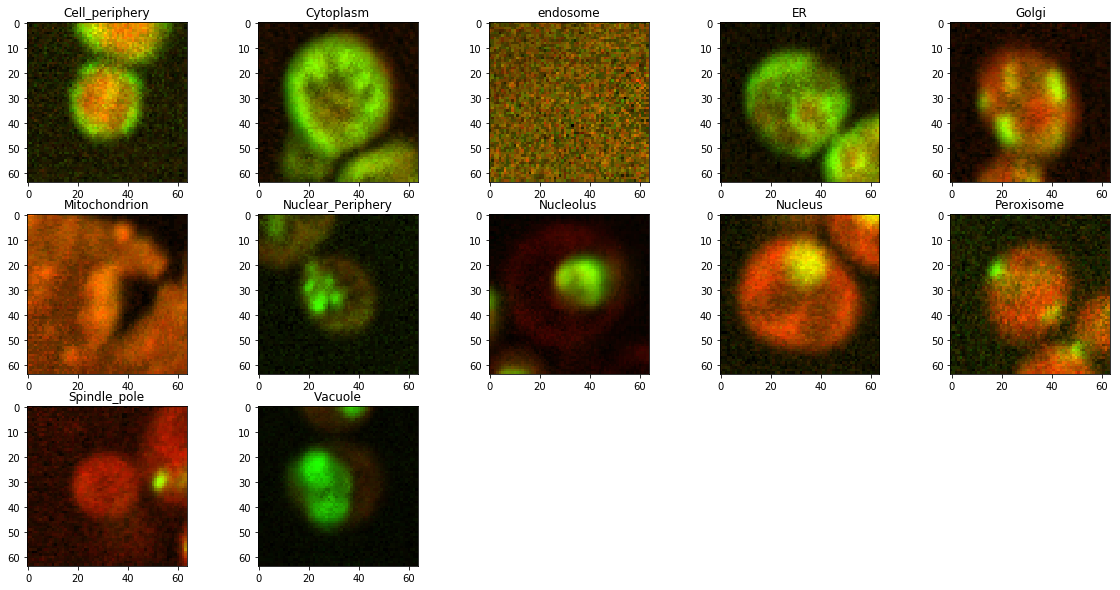

In [0]:
import kwb.utils
import numpy as np
#as a batch
images  = []
for i in range(12):
    for k,n in enumerate(np.argmax(y_train,axis=1)):
        if n == i:
            images.append(X_train[k])
            break
        else:
            pass
images = np.array(images)


plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    image = equalize_adapthist(image)
    plt.title(label_names[i])
    plt.imshow(image)

# Model construction and training
According to [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5427497/]

>We used 3 × 3 patterns with step size (stride) 1 for convolutional layers, 2 × 2 aggregation regions with step size 2 for pooling layers, and rectified linear unit nonlinearities for the activation function. The number of units in the convolutional layers was 64, 64, 128, 128, 256, 256, 256, and 256, and in the fully connected layers was 512, 512, and 12. We initialized the weights using the Glorot-normal initialization technique (Glorot and Bengio 2010), and used batch normalization (Ioffe and Szegedy 2015) after each convolutional or fully connected layer, but before activation functions. For each image, per-pixel training set mean was subtracted before use. Cross-entropy loss was minimized using stochastic gradient descent with momentum of 0.9, initial learning rate of 0.1, and a mini-batch size of 100. Learning rate was divided by two after every 16,250 iterations (25 epochs). To reduce overfitting, we used weight decay of 0.0005, and dropout with rate of 0.5 for the first two fully connected layers. The models were trained for 195,000 iterations (300 epochs over full training data), and based on validation loss, the model at iteration 130,000 was chosen for all experiments.

I will try to mimick the above conditions as possible with keras

In [0]:
model = deepyeast.DeepYeast_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 64)        0         
__________

### will not do the actual training.

import keras

learning rate scheduler that drops the learning rate by half per 25 epoch.

lrate = keras.callbacks.LearningRateScheduler(deepyeast.step_decay)

earlystop = keras.callbacks.EarlyStopping(patience=10,verbose=1)

bestmodel = keras.callbacks.ModelCheckpoint("DeepYeast_Bestmodel.hdf5",save_best_only=True)

model.fit(X_train, y_train,
                    epochs=300,batch_size = 100,callbacks=[lrate,earlystop,bestmodel],
                   validation_data=(X_valid,y_valid))

In [0]:
model.load_weights("DeepYeast_Bestmodel.hdf5")

## model evaluation

let's evaluate the model

In [0]:
#lets see what kind of metrics can be obtained
print(model.metrics_names) 

['loss', 'acc']


in addition to loss, acc (accuracy) is added to the metric since it was built in when compiling the model. below is a line from deepyeast.py, DeepYeast_model()

>model.compile(sgd,loss="categorical_crossentropy",metrics=["acc"])

the above metric can be obtained from model.evaluate

In [0]:
print(model.evaluate(X_train,y_train))
print(model.evaluate(X_valid,y_valid))
print(model.evaluate(X_test,y_test))

65000/65000 [==============================] - 24s 376us/step
[0.27340240261554716, 0.9644307692307692]
12500/12500 [==============================] - 5s 367us/step
[0.5828538463211059, 0.8745599999618531]
12500/12500 [==============================] - 5s 368us/step
[0.6355924955177307, 0.863519999961853]


In [0]:
label_name = deepyeast.load_label_names() #label name that corresponds to the label number in dataset
true_y = np.argmax(y_test,axis=1) #the true label of dataset
pred_y = np.argmax(model.predict(X_test),axis=1) #predicted label of dataset

evaluation summary function by sklearn.

In [0]:
print(classification_report(true_y,pred_y,target_names=label_name))

                   precision    recall  f1-score   support

   Cell_periphery       0.97      0.87      0.92      1569
        Cytoplasm       0.84      0.92      0.88      1276
         endosome       0.62      0.83      0.71       689
               ER       0.89      0.92      0.91      1755
            Golgi       0.92      0.82      0.87       382
    Mitochondrion       0.89      0.90      0.90      1243
Nuclear_Periphery       0.94      0.89      0.92      1164
        Nucleolus       0.85      0.92      0.89      1263
          Nucleus       0.95      0.82      0.88      1627
       Peroxisome       0.53      0.81      0.64       164
     Spindle_pole       0.81      0.57      0.67       781
          Vacuole       0.74      0.88      0.80       587

      avg / total       0.87      0.86      0.86     12500



let's get the confusion matrix, also using the sklearn function

In [0]:
import kwb.utils

cnf = confusion_matrix(true_y, pred_y)
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
kwb.utils.plot_confusion_matrix(cnf, classes=label_name,
                      title='Confusion matrix',normalize=True)

NameError: name 'confusion_matrix' is not defined

In [0]:
X_train, y_train, X_valid, y_valid,X_test,y_test = load_data(transfer=True)
print(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,)

/home/dl-box/anaconda3/envs/keras/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(4000, 64, 64, 3) (4000, 4) (2000, 64, 64, 3) (2000, 4)


In [0]:
#transfer learning with random forest.
from keras.models import Model
from keras import layers
from sklearn.ensemble import RandomForestClassifier

for layer in model.layers:
    layer.trainable = False    
intlayer = model.get_layer(index=-2).output #get value before the last layer
intmodel = Model(inputs=model.input,outputs=intlayer)

int_X_train = intmodel.predict(X_train)
int_X_test = intmodel.predict(X_test)
print(int_X_train.shape,int_X_test.shape)

clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(int_X_train,np.argmax(y_train,axis=1))
print("accuracy on train data:", clf.score(int_X_train,np.argmax(y_train,axis=1)))
print("accuracy on test data:", clf.score(int_X_test,np.argmax(y_test,axis=1)))

accuracy on train data: 0.7155
accuracy on test data: 0.61475


In [0]:
#another transfer learning that connects new dense layer to the learnt network
import keras.backend as K

K.clear_session()

model =DeepYeast()
model.load_weights("DeepYeast_Bestmodel.hdf5")
for layer in model.layers:
    layer.trainable=False
intlayer = model.get_layer(index=-2).output #get value before the last layer

x = layers.Dense(4, activation='softmax', name='predictions')(intlayer)

transfermodel = Model(inputs=model.input,outputs=x)
transfermodel.summary() #note that trainable parameters are limited to dense layers only
transfermodel.compile("sgd",loss="categorical_crossentropy",metrics=["acc"])

bestmodel = keras.callbacks.ModelCheckpoint("DeepYeast_Bestmodel_transfer.hdf5",save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 64)        0         
__________

In [0]:
transfermodel.fit(X_train, y_train,
                    epochs=50,batch_size = 100,callbacks=[bestmodel],
                   validation_data=(X_valid,y_valid))

Train on 4000 samples, validate on 2000 samples
Epoch 1/50
4000/4000 [==============================] - 2s 539us/step - loss: 1.5590 - acc: 0.4062 - val_loss: 1.2991 - val_acc: 0.4590
Epoch 2/50
4000/4000 [==============================] - 2s 429us/step - loss: 1.1935 - acc: 0.5527 - val_loss: 1.2290 - val_acc: 0.4830
Epoch 3/50
4000/4000 [==============================] - 2s 444us/step - loss: 1.1040 - acc: 0.5940 - val_loss: 1.1880 - val_acc: 0.5135
Epoch 4/50
4000/4000 [==============================] - 2s 431us/step - loss: 1.0418 - acc: 0.6100 - val_loss: 1.1516 - val_acc: 0.5360
Epoch 5/50
4000/4000 [==============================] - 2s 438us/step - loss: 1.0395 - acc: 0.6255 - val_loss: 1.1372 - val_acc: 0.5465
Epoch 6/50
4000/4000 [==============================] - 2s 440us/step - loss: 0.9982 - acc: 0.6468 - val_loss: 1.1202 - val_acc: 0.5505
Epoch 7/50
4000/4000 [==============================] - 2s 444us/step - loss: 0.9758 - acc: 0.6480 - val_loss: 1.1049 - val_acc: 0.5595


In [0]:
print(transfermodel.evaluate(X_train,y_train))
print(transfermodel.evaluate(X_valid,y_valid))
print(transfermodel.evaluate(X_test,y_test))

4000/4000 [==============================] - 1s 362us/step
[0.7705937781333924, 0.76175]
2000/2000 [==============================] - 1s 365us/step
[1.1149951038360595, 0.571]
4000/4000 [==============================] - 1s 357us/step
[0.9392598533630371, 0.669]


In [0]:
#with recent model
K.clear_session()
